In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
#Load and fix dataset
csv_path = '/content/truevsfakenews.csv'

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"File not found: {csv_path}")

# Load with no header and assign column names
data = pd.read_csv(csv_path, header=None, names=['text', 'label'])

# Strip whitespace from column names
data.columns = data.columns.str.strip()

# Display structure
print("Column names:", data.columns.tolist())
print("Sample data:\n", data.head())

Column names: ['text', 'label']
Sample data:
                                                 text label
0  WASHINGTON (Reutext,label\nters) - The Republi...  true
1  Women should get as far away from Oklahoma as ...  fake
2  Another huge crowd of Americans tuned in last ...  fake
3  Donald Trump is desperate to stop the investig...  fake
4  (Reuters) - Planned Parenthood, the U.S. medic...  true


In [5]:
#Clean data
data = data.dropna(subset=['text', 'label'])
data['text'] = data['text'].astype(str)

In [6]:
!pip install contractions
import contractions
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['cleaned_text'] = data['text'].apply(preprocess_text)
data = data[data['cleaned_text'].str.strip() != '']

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 7.4 MB/s eta 0:00:00


In [7]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

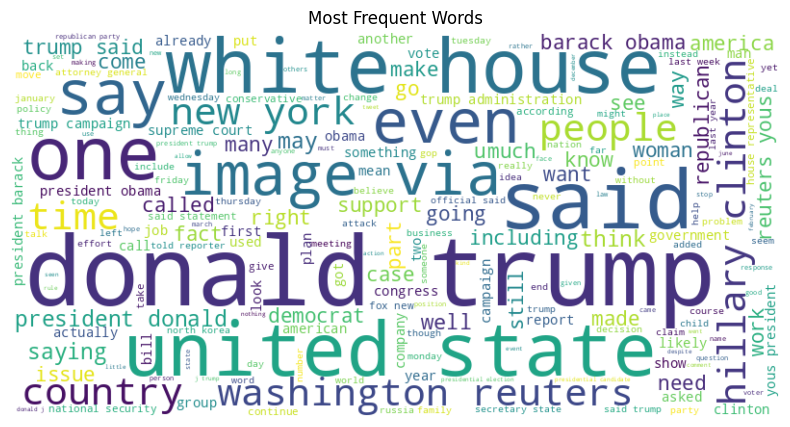

In [8]:
# Combine all cleaned text
all_words = ' '.join(data['cleaned_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot it
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words')
plt.show()


In [9]:
#Filter labels and tokenize text
print("Unique labels in dataset:", data['label'].unique())
valid_labels = ['true', 'fake']
data = data[data['label'].isin(valid_labels)]

if data.empty:
    raise ValueError("Dataset is empty after filtering labels.")

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data['cleaned_text'])
X_sequences = tokenizer.texts_to_sequences(data['cleaned_text'])

# Padding
max_len = 100
X_pad = pad_sequences(X_sequences, maxlen=max_len, padding='post')

# Encode labels
le = LabelEncoder()
y = le.fit_transform(data['label'])

# Train-test split
X_train_pad, X_test_pad, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Convert to arrays
X_train_pad = np.array(X_train_pad, dtype='int32')
X_test_pad = np.array(X_test_pad, dtype='int32')
y_train = np.array(y_train, dtype='float32')
y_test = np.array(y_test, dtype='float32')

print("Shapes:")
print("X_train_pad:", X_train_pad.shape)
print("y_train:", y_train.shape)

Unique labels in dataset: ['true' 'fake']
Shapes:
X_train_pad: (15998, 100)
y_train: (15998,)


In [10]:
#Build RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim=128))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
#Train model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def train_model(model, X_train, y_train, X_val, y_val, model_name):
    checkpoint = ModelCheckpoint(f'best_{model_name}_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stop])
    return history

rnn_history = train_model(rnn_model, X_train_pad, y_train, X_test_pad, y_test, 'rnn')

Epoch 1/10
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9084 - loss: 0.2309
Epoch 1: val_accuracy improved from -inf to 0.97575, saving model to best_rnn_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.9088 - loss: 0.2301 - val_accuracy: 0.9758 - val_loss: 0.0721
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9717 - loss: 0.1027
Epoch 2: val_accuracy did not improve from 0.97575
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.9716 - loss: 0.1030 - val_accuracy: 0.9582 - val_loss: 0.1582
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9721 - loss: 0.1029
Epoch 3: val_accuracy did not improve from 0.97575
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9721 - loss: 0.1029 - val_accuracy: 0.9680 - val_loss: 0.1042
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9800 - loss: 0.0710
Epoch 4: val_accuracy did not improve from 0.97575
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.9800 - loss: 0.0710 - val_accuracy: 0.9697 - val_loss: 0.0988
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [12]:
from tensorflow.keras.layers import LSTM
# LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train LSTM model
lstm_history = train_model(lstm_model, X_train_pad, y_train, X_test_pad, y_test, 'lstm')

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9158 - loss: 0.2359
Epoch 1: val_accuracy improved from -inf to 0.98175, saving model to best_lstm_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 163ms/step - accuracy: 0.9160 - loss: 0.2355 - val_accuracy: 0.9818 - val_loss: 0.0625
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9883 - loss: 0.0460
Epoch 2: val_accuracy improved from 0.98175 to 0.98275, saving model to best_lstm_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.9883 - loss: 0.0460 - val_accuracy: 0.9827 - val_loss: 0.0602
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9956 - loss: 0.0190
Epoch 3: val_accuracy did not improve from 0.98275
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 158ms/step - accuracy: 0.9956 - loss: 0.0190 - val_accuracy: 0.9805 - val_loss: 0.0634
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9973 - loss: 0.0116
Epoch 4: val_accuracy did not improve from 0.98275
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 189ms/step - accuracy: 0.9973 - loss: 0.0117 - val_accuracy: 0.9775 - val_loss: 0.0859
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9982 - loss: 0.0087
Epoch 5: val_accuracy did not improve from 0.98275
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 159ms/step - accuracy: 0.9982 - loss: 0.0087 - val_accuracy: 0.9810 - val_loss: 0.0702
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [14]:
# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [15]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_classes)
    cm = confusion_matrix(y_test, y_pred_classes)
    cr = classification_report(y_test, y_pred_classes)
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

In [16]:
# Check for NaN values in y_test
nan_indices = np.isnan(y_test)

In [17]:
# Print the number of NaN values
print(f"Number of NaN values in y_test: {np.sum(nan_indices)}")

Number of NaN values in y_test: 0


In [18]:
# Evaluate RNN model
evaluate_model(rnn_model, X_test_pad, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy: 0.9758
Confusion Matrix:
[[1947   67]
 [  30 1956]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      2014
         1.0       0.97      0.98      0.98      1986

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



In [19]:
# Evaluate the model with the cleaned data
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_classes)
    cm = confusion_matrix(y_test, y_pred_classes)
    cr = classification_report(y_test, y_pred_classes)
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

In [20]:
# Evaluate LSTM model
evaluate_model(lstm_model, X_test_pad, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Accuracy: 0.9828
Confusion Matrix:
[[1963   51]
 [  18 1968]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      2014
         1.0       0.97      0.99      0.98      1986

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



In [21]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

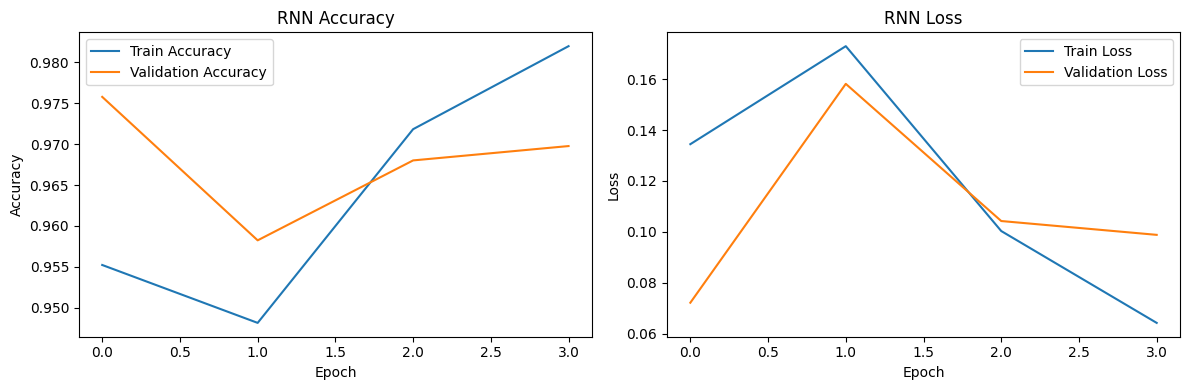

In [22]:
# Plot RNN history
plot_history(rnn_history, 'RNN')

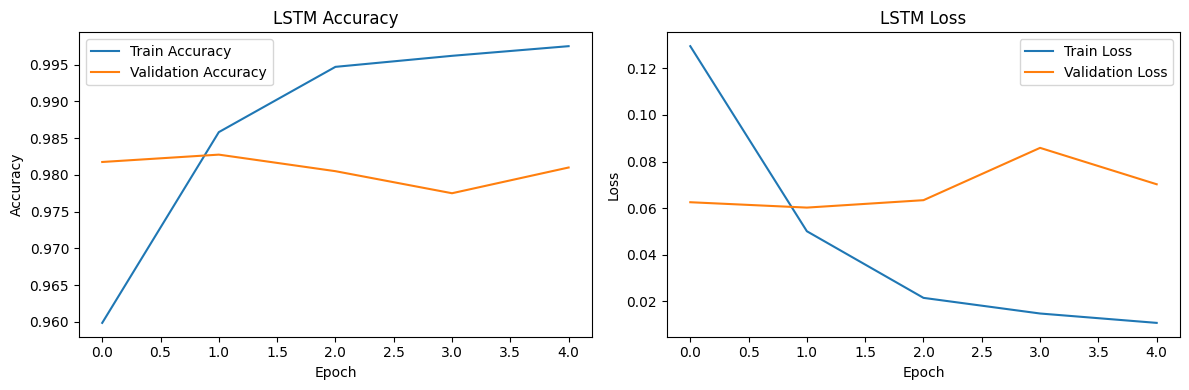

In [23]:
# Plot LSTM history
plot_history(lstm_history, 'LSTM')

In [28]:
!pip install gensim
import gensim.downloader as api

# Download pretrained Word2Vec model (takes time and space ~1.6GB)
word2vec_model = api.load("word2vec-google-news-300")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [29]:
embedding_dim = 300  # Word2Vec Google News vectors are 300-dimensional
word_index = tokenizer.word_index
num_words = min(10000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= num_words:
        continue
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

word2vec_lstm_model = Sequential()
word2vec_lstm_model.add(Embedding(input_dim=num_words,
                                   output_dim=embedding_dim,
                                   weights=[embedding_matrix],
                                   input_length=max_len,
                                   trainable=False))  # freeze embeddings
word2vec_lstm_model.add(LSTM(64))
word2vec_lstm_model.add(Dense(1, activation='sigmoid'))

word2vec_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
word2vec_lstm_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [31]:
word2vec_history = train_model(word2vec_lstm_model, X_train_pad, y_train, X_test_pad, y_test, 'word2vec_lstm')


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9336 - loss: 0.2242
Epoch 1: val_accuracy improved from -inf to 0.96875, saving model to best_word2vec_lstm_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 168ms/step - accuracy: 0.9337 - loss: 0.2238 - val_accuracy: 0.9688 - val_loss: 0.0841
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9731 - loss: 0.0788
Epoch 2: val_accuracy improved from 0.96875 to 0.97625, saving model to best_word2vec_lstm_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 162ms/step - accuracy: 0.9731 - loss: 0.0788 - val_accuracy: 0.9762 - val_loss: 0.0692
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9794 - loss: 0.0625
Epoch 3: val_accuracy improved from 0.97625 to 0.98175, saving model to best_word2vec_lstm_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.9794 - loss: 0.0625 - val_accuracy: 0.9818 - val_loss: 0.0580
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9852 - loss: 0.0452
Epoch 4: val_accuracy improved from 0.98175 to 0.98225, saving model to best_word2vec_lstm_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 172ms/step - accuracy: 0.9852 - loss: 0.0452 - val_accuracy: 0.9822 - val_loss: 0.0546
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9863 - loss: 0.0404
Epoch 5: val_accuracy did not improve from 0.98225
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 165ms/step - accuracy: 0.9863 - loss: 0.0404 - val_accuracy: 0.9805 - val_loss: 0.0543
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9900 - loss: 0.0336
Epoch 6: val_accuracy did not improve from 0.98225
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 171ms/step - accuracy: 0.9900 - loss: 0.0336 - val_accuracy: 0.9808 - val_loss: 0.0575
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9862 - loss: 0.0403
Epoch 7: val_accuracy did not improve from 0.98225
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 196ms/step - accuracy: 0.9862 - loss: 0.0403 - val_accuracy: 0.9812 - val_loss: 0.0600
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9924 - loss: 0.0269
Epoch 8: val_ac

250/250 ━━━━━━━━━━━━━━━━━━━━ 73s 161ms/step - accuracy: 0.9924 - loss: 0.0269 - val_accuracy: 0.9840 - val_loss: 0.0547
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.


125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step
Accuracy: 0.9805
Confusion Matrix:
[[1983   31]
 [  47 1939]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2014
         1.0       0.98      0.98      0.98      1986

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



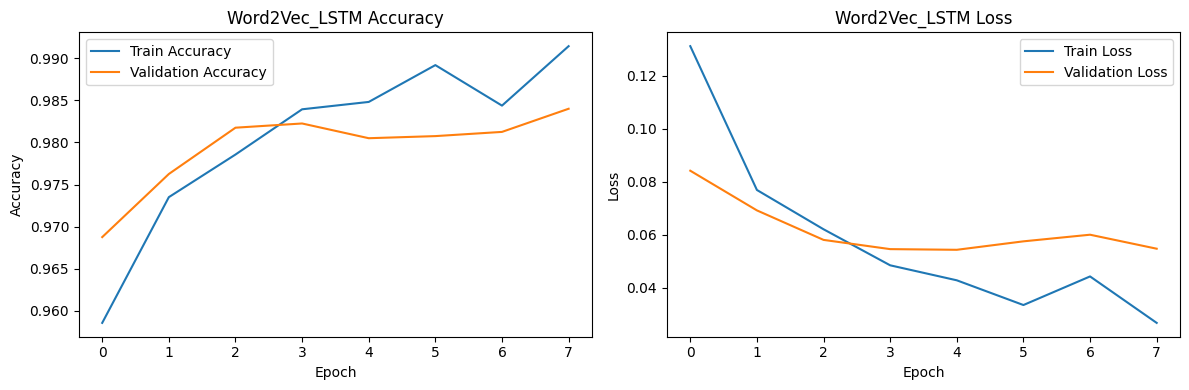

In [32]:
evaluate_model(word2vec_lstm_model, X_test_pad, y_test)
plot_history(word2vec_history, 'Word2Vec_LSTM')

In [24]:
def predict_sentiment(text):
    cleaned_input = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_input])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    prediction = lstm_model.predict(padded_sequence)[0][0]

    label = "True" if prediction > 0.5 else "Fake"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    confidence_percent = round(confidence * 100, 2)

    return f"Prediction: {label} ({confidence_percent}% confidence)"


In [25]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00


In [26]:
import gradio as gr

iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=2, placeholder="Enter a tweet..."),
    outputs=gr.Text()
)

In [27]:
# Launch the interface
iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1a4c7e57e26c0d1caa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
